# Generic PyEMMA analysis pipeline for DESRES folding trajectories

This notebook illustrates how to perform a simple folding analysis using the PyEMMA package on the example of CLN025 from Kresten Lindorff-Larsen et al paper. If you have any questions, please refer to the official [PyEMMA documentation](http://pyemma.org), the developer community on [Github](https://github.com/markovmodel/PyEMMA) or contact me directly via ``christoph.wehmeyer@fu-berlin.de``.

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
import mdtraj as md
from glob import glob

## Define auxiliary functions

Here, we define a set of functions which will make plotting easier.

In [6]:
def plot_its(lags, model, bayesian_model, ax, ylabel, dt=2.0E-4, confidence_interval=0.98):
    cout = 50 * (1.0 - confidence_interval)
    ax.fill_between(
        lags * dt,
        0.0,
        lags * dt,
        alpha=0.5, facecolor='grey')
    ax.plot(lags * dt, lags * dt, linewidth=2, color='black')
    for i in range(model.shape[1]):
        ax.fill_between(
            lags * dt,
            np.percentile(bayesian_model[:, :, i], cout, axis=1),
            np.percentile(bayesian_model[:, :, i], 100 - cout, axis=1),
            alpha=0.3, facecolor='C%d' % i)
        ax.plot(lags * dt, model[:, i], color='C%d' % i)
        ax.plot(lags * dt, np.median(bayesian_model[:, :, i], axis=1), ':o', color='C%d' % i)
    ax.set_xlabel(r'lagtime / $\mu$s')
    ax.set_ylabel(ylabel)

def plot_mfpt(lags, model, bayesian_model, ax, ylabel, dt=2.0E-4, confidence_interval=0.98,p_target=None):
    cout = 50 * (1.0 - confidence_interval)
    ax.fill_between(
        lags * dt,
        np.percentile(bayesian_model, cout, axis=1),
        np.percentile(bayesian_model, 100 - cout, axis=1),
        alpha=0.3)
    ax.plot(lags * dt, model)
    ax.plot(lags * dt, np.median(bayesian_model, axis=1), ':o', color='C0')
    
    if p_target is not None:
        ax.plot(lags * dt, lags * dt/p_target)
    
    ax.set_xlabel(r'lagtime / $\mu$s')
    ax.set_ylabel(ylabel)
    
def get_lagtime_from_array(lags, lagtime, dt=2.0E-4):
    idx = np.argmin(np.abs(lags * dt - lagtime))
    return idx, lags[idx]

def get_free_energy(tics, bins=100, use=[0, 1]):
    z, xedge, yedge = np.histogram2d(*tics[:, use].T, bins=bins)
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])
    z = np.maximum(z, np.min(z[z > 0]))
    f = -np.log(z)
    f -= np.min(f)
    xx, yy = np.meshgrid(x, y)
    xy = np.array([xx.reshape(-1,), yy.reshape(-1,)]).T
    return dict(x=x, y=y, xx=xx, yy=yy, xy=xy, f=f.T, use=use)

def draw_states(fe, centers, msa, ax, alpha=None):
    nstates = msa.max() + 2
    zz = msa[pyemma.coordinates.assign_to_centers(fe['xy'], centers=centers[:, fe['use']])[0]]
    zz = zz.reshape(fe['xx'].shape)
    ax.contour(fe['xx'], fe['yy'], zz, np.arange(0, nstates, 1), colors='black', linewidths=2.0)
    return ax.contourf(fe['xx'], fe['yy'], zz, np.arange(0, nstates, 1) - 0.5, alpha=alpha)

def draw_free_energy(fe, ax, bw=False):
    if bw:
        cmap = mpl.cm.bone
        alpha=0.2
    else:
        cmap = mpl.cm.jet
        alpha=None
    levels = np.linspace(fe['f'].min(), fe['f'].max(), 100, endpoint=False)
    return ax.contourf(fe['x'], fe['y'], fe['f'], levels, cmap=cmap, alpha=alpha, vmin=0.0, vmax=np.max(fe['f']))

def plot_cg(fe, centers, model, ax, title):
    cbar = fig.colorbar(draw_states(fe, cluster.clustercenters, model.metastable_assignments, ax), ax=ax)
    cbar.set_label('metastable set')
    cbar.set_ticks(np.arange(0, len(model.metastable_sets), 1))
    draw_free_energy(fe, ax, bw=True)
    ax.scatter(*cluster.clustercenters[model.metastable_sets[0], :].T, marker='+', label='0', c='red')
    ax.scatter(*cluster.clustercenters[model.metastable_sets[1], :].T, marker='x', label='1', c='red')
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel('TIC 1')
    ax.set_ylabel('TIC 2')

def get_metastable_distribution(model, state):
    pi = model.stationary_distribution.copy()
    for i, s in enumerate(model.metastable_sets):
        if i == state:
            continue
        pi[s] = 0.0
    pi /= pi.sum()
    return pi

def mfpts_no_model(sequence, stateA, stateB, dt=1.0):
    passageTimeAB = []
    passageTimeBA = []
    fpt_counter = 0
    
    previous_color = "Unknown"
    
    for snapshot in sequence:
        #state and color determination
        if snapshot in stateA:
            color = "A"
        elif snapshot in stateB:
            color = "B"
        else:
            color = previous_color

        #passage times
        if (color == "A") or (color == "B"):
            fpt_counter += 1

        if previous_color == "A" and color == "B":
            passageTimeAB.append(fpt_counter)
            fpt_counter = 0
        elif previous_color=="B" and color=="A":
            passageTimeBA.append(fpt_counter)
            fpt_counter = 0
        elif previous_color == "Unknown" and (color == "A" or color == "B"):
            fpt_counter = 0

        previous_color = color

    try:
        mfptAB = float(sum(passageTimeAB))/len(passageTimeAB) * dt
        std_err_mfptAB = np.std(passageTimeAB)/np.sqrt(len(passageTimeAB)) * dt
    except:
        print('WARNING: No A->B events observed')
        mfptAB = 'NaN'
        std_err_mfptAB = 'NaN'

    try:
        mfptBA = float(sum(passageTimeBA))/len(passageTimeBA) * dt
        std_err_mfptBA = np.std(passageTimeBA)/np.sqrt(len(passageTimeBA)) * dt
    except:
        print('WARNING: No B->A events observed')
        mfptBA = 'NaN'
        std_err_mfptBA = 'NaN'

    kinetics = {'mfptAB': mfptAB, 'std_err_mfptAB': std_err_mfptAB, 'mfptBA': mfptBA, 'std_err_mfptBA': std_err_mfptBA}

    return kinetics

        

## Create a feature reader

We create a feature reader to obtain minimal distances between all residues which are not close neighbours. Feel free to map these distances to binary contacts or use inverse minimal residue distances instead. These coices usually work quite well.

In [7]:
traj_files = [f for f in sorted(glob('CLN025-0-protein/CLN025-0-protein-*.dcd'))]
pdb_file = 'CLN025-0-protein/chig_pdb_166.pdb'

features = pyemma.coordinates.featurizer(pdb_file)
features.add_residue_mindist()
source = pyemma.coordinates.source([traj_files], features=features, chunk_size=10000)

20-05-17 13:16:03 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[3] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


## Discretisation

We start the actual analysis with a TICA projection onto two components on which we perform a k-means clustering. Then, we take a quick view on the implied timescale convergence, the 2D representation, and the clustering:

20-05-17 13:17:19 pyemma.coordinates.clustering.kmeans.KmeansClustering[6] INFO     Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
[array([63, 27, 31, ..., 48, 12, 33], dtype=int32)]


/home/esuarez/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


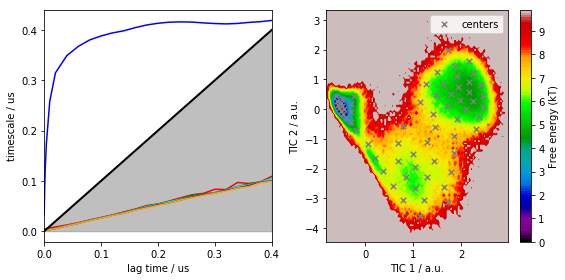

In [8]:
tica = pyemma.coordinates.tica(data=source, lag=5, dim=2).get_output()[0]
cluster = pyemma.coordinates.cluster_kmeans(tica, k=64, max_iter=50)
print(cluster.dtrajs)

lags = np.asarray([1, 5, 10, 20, 50] + [i * 100 for i in range(1, 21)])
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(cluster.dtrajs, lags=lags, errors=None, nits=6),
    ylog=False, ax=axes[0], units='us', dt=2.0E-4)
pyemma.plots.plot_free_energy(*tica.T, ax=axes[1])
axes[1].scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
axes[1].legend()
axes[1].set_xlabel('TIC 1 / a.u.')
axes[1].set_ylabel('TIC 2 / a.u.')
fig.tight_layout()

We observe that only one slow process remains with roughly converged implied timescales (ITS) at lag time $\tau\geq0.2\mu s$. The TICA projection shows a deep free energy minimum on the right side and another, larger well on the right.

## MSM estimation and analysis

We estimate maximum likelihood MSMs at a range of lag times, as well as Bayesian-sampled MSMs to obtain error bars, and we perform a PCCA++ run for each model to find the two most metastable sets. For these estimated models, we plot (again) the ITS convergence and the mean first passage times (MFPT) between the metastable states:

In [9]:
msm = [pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us') for lag in lags]
bmsm = [pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us', nsamples=100) for lag in lags]

msm_timescale = np.asarray([m.timescales(k=4) for m in msm])
bmsm_timescale = np.asarray([[s.timescales(k=4) for s in m.samples] for m in bmsm])

for i, m in enumerate(msm + bmsm):
    m.pcca(2)

msm_mfpt01 = np.asarray([m.mfpt(m.metastable_sets[0], m.metastable_sets[1]) for m in msm])
msm_mfpt10 = np.asarray([m.mfpt(m.metastable_sets[1], m.metastable_sets[0]) for m in msm])
bmsm_mfpt01 = np.asarray([[s.mfpt(m.metastable_sets[0], m.metastable_sets[1]) for s in m.samples] for m in bmsm])
bmsm_mfpt10 = np.asarray([[s.mfpt(m.metastable_sets[1], m.metastable_sets[0]) for s in m.samples] for m in bmsm])

Prob. folded:    0.7808704368266626
Prob. unfolded:  0.21912956317333748
0.655838356841
2.39016570612

 {'mfptAB': 0.053397058823529416, 'std_err_mfptAB': 0.0039073421947357096, 'mfptBA': 0.01497468030690537, 'std_err_mfptBA': 0.001055320453712615}


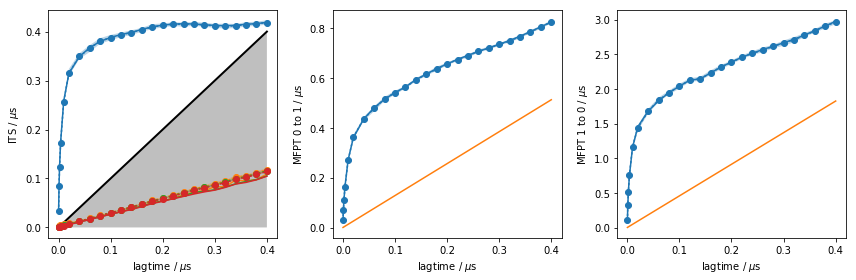

In [10]:
bestmodel = msm[14]
folded = bestmodel.metastable_sets[1]
unfolded = bestmodel.metastable_sets[0]
#print(folded)
#print(unfolded)

count_fold = 0
count_unfold = 0
for element in list(cluster.dtrajs[0]):
    if element in folded:
        count_fold +=1
    elif element in unfolded:
        count_unfold +=1
    else:
        print(element)
        print("big trouble")
        break
print("Prob. folded:   ", count_fold/(count_fold+count_unfold))
print("Prob. unfolded: ", count_unfold/(count_fold+count_unfold))

print(msm_mfpt01[14])
print(msm_mfpt10[14])
#print(lags)



fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_its(lags, msm_timescale, bmsm_timescale, axes[0], r'ITS / $\mu$s')
plot_mfpt(lags, msm_mfpt01, bmsm_mfpt01, axes[1], r'MFPT 0 to 1 / $\mu$s',p_target=0.7809134)
plot_mfpt(lags, msm_mfpt10, bmsm_mfpt10, axes[2], r'MFPT 1 to 0 / $\mu$s',p_target=0.219086)
fig.tight_layout()

print('\n',mfpts_no_model(cluster.dtrajs[0],folded,unfolded,dt=0.0002))

We observe the same ITS convergence we saw before and the expected linear increase of the MFPTs above a certain lag time.

## HMM estimation and analysis

Now, we repeat the above analysis with hidden Markov models (HMM) where we assume two hidden states and plot the ITS convergence and MFPTs between the hiden states:

/home/esuarez/anaconda3/lib/python3.6/site-packages/msmtools/analysis/dense/decomposition.py:540: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)
/home/esuarez/anaconda3/lib/python3.6/site-packages/msmtools/analysis/dense/decomposition.py:540: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)
/home/esuarez/anaconda3/lib/python3.6/site-packages/msmtools/analysis/dense/decomposition.py:540: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)
/home/esuarez/anaconda3/lib/python3.6/site-packages/msmtools/analysis/dense/decomposition.py:540: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eig

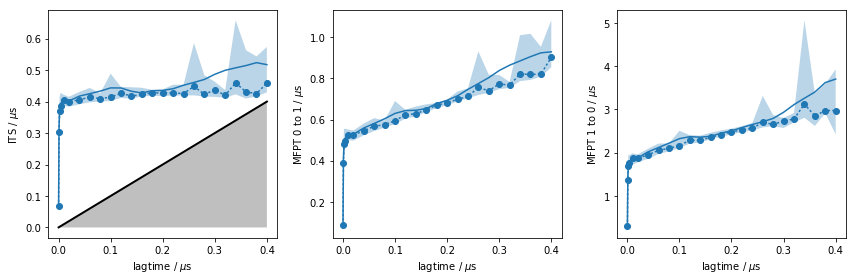

In [11]:
hmm = [pyemma.msm.estimate_hidden_markov_model(cluster.dtrajs, nstates=2, lag=lag, dt_traj='0.0002 us') for lag in lags]
bhmm = [pyemma.msm.bayesian_hidden_markov_model(
    cluster.dtrajs, nstates=2, lag=lag, dt_traj='0.0002 us', nsamples=100) for lag in lags]

hmm_timescale = np.asarray([m.timescales(k=1) for m in hmm],)
bhmm_timescale = np.asarray([[s.timescales(k=1) for s in m.samples] for m in bhmm])

hmm_mfpt01 = np.asarray([m.mfpt(0, 1) for m in hmm])
hmm_mfpt10 = np.asarray([m.mfpt(1, 0) for m in hmm])
bhmm_mfpt01 = np.asarray([[s.mfpt(0, 1) for s in m.samples] for m in bhmm])
bhmm_mfpt10 = np.asarray([[s.mfpt(1, 0) for s in m.samples] for m in bhmm])

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_its(lags, hmm_timescale, bhmm_timescale, axes[0], r'ITS / $\mu$s')
plot_mfpt(lags, hmm_mfpt01, bhmm_mfpt01, axes[1], r'MFPT 0 to 1 / $\mu$s')
plot_mfpt(lags, hmm_mfpt10, bhmm_mfpt10, axes[2], r'MFPT 1 to 0 / $\mu$s')
fig.tight_layout()

Here, the ITS converge much faster, as is expected for HMMs, and a quicker onset of the linear MFPT regime than for the MSM case. Comparing the values directly, we find that the ITS as well as the MFPT estimates are in good agreement between HMMs and MSMs.

## MSM validation

For the MSM case, have observed a flat ITS plateau from $\tau\geq0.2\mu s$. We will now plot the result of a Chapman-Kolmogorov test for a selected lag time with flat ITS:

Selected lagtime: 1000 steps


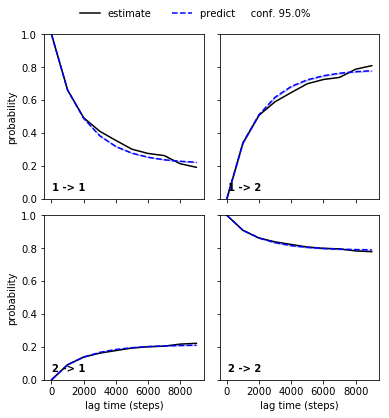

In [12]:
idx, lag = get_lagtime_from_array(lags, 0.2)

pyemma.plots.plot_cktest(bmsm[idx].cktest(2))
print('Selected lagtime: %d steps' % lag)

Now we have a model with a reasonable level of validation.

## MFPTs between metastable states

Finally, we compute MFPTs between metastable sets for a selected and validated MSM and compare with a suitable HMM result:

14
MSM at lagtime 1000 steps (0.20 microseconds)
HMM at lagtime   50 steps (0.01 microseconds)

MFPT[0,1]:
     MSM = 0.656 +/- 0.003 microseconds
     HMM = 0.526 +/- 0.014 microseconds

MFPT[1,0]:
     MSM = 2.390 +/- 0.012 microseconds
     HMM = 1.869 +/- 0.061 microseconds


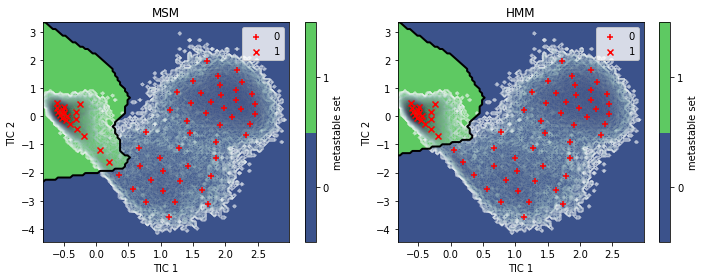

In [13]:
idx, lag = get_lagtime_from_array(lags, 0.2)
print(idx)
idx_hmm = 4

fe = get_free_energy(tica)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_cg(fe, cluster.clustercenters, msm[idx], axes[0], 'MSM')
plot_cg(fe, cluster.clustercenters, hmm[idx_hmm], axes[1], 'HMM')
fig.tight_layout()

print('MSM at lagtime %4d steps (%.2f microseconds)' % (lag, lag * 2.0E-4))
print('HMM at lagtime %4d steps (%.2f microseconds)' % (lags[idx_hmm], lags[idx_hmm] * 2.0E-4))

print('\nMFPT[0,1]:')
print('     MSM = %5.3f +/- %5.3f microseconds' % (msm_mfpt01[idx], np.std(bmsm_mfpt01[idx], ddof=1)))
print('     HMM = %5.3f +/- %5.3f microseconds' % (hmm_mfpt01[idx_hmm], np.std(bhmm_mfpt01[idx_hmm], ddof=1)))

print('\nMFPT[1,0]:')
print('     MSM = %5.3f +/- %5.3f microseconds' % (msm_mfpt10[idx], np.std(bmsm_mfpt10[idx], ddof=1)))
print('     HMM = %5.3f +/- %5.3f microseconds' % (hmm_mfpt10[idx_hmm], np.std(bhmm_mfpt10[idx_hmm], ddof=1)))

We observe that all calculated MFPT values are well within the uncertainties reported in the Lindorff-Larsen paper. To check that this abstract analysis has indeed captured the right process between the folded and unfolded state, we sample frames according to the MSM-computed stationary distributions restricted to either metastable state 0 or state 1 and save these frames in two separate DCD files:

In [14]:
distributions = [get_metastable_distribution(msm[idx], i) for i in [0, 1]]

for i, indexes in enumerate(msm[idx].sample_by_distributions(distributions, 100)):
    pyemma.coordinates.save_traj([traj_files], indexes, 'out-%d.dcd' % i, top=pdb_file)

20-05-17 13:29:56 pyemma.coordinates.api INFO     Created file out-0.dcd
20-05-17 13:29:56 pyemma.coordinates.api INFO     Created file out-1.dcd


An inspection of ``out-0.dcd`` and ``out-1.dcd`` shows that the sample from state 0 has only unfolded configurations while the sample of state 1 contains only folded structures. Thus, we can conclude:

In [15]:
print('MFPT[unfolded to folded] = %5.3f +/- %5.3f microseconds' % (msm_mfpt01[idx], np.std(bmsm_mfpt01[idx], ddof=1)))
print('MFPT[folded to unfolded] = %5.3f +/- %5.3f microseconds' % (msm_mfpt10[idx], np.std(bmsm_mfpt10[idx], ddof=1)))

MFPT[unfolded to folded] = 0.656 +/- 0.003 microseconds
MFPT[folded to unfolded] = 2.390 +/- 0.012 microseconds


Thus, we have correctly found the folding and unfolding MFPTs within the uncertainties reported by Lindorff-Larsen et al respectively the criterion for good models denoted in Suaréz et al.